# Lab 09 XOR - tensorboard - eager
* XOR 문제를 Deep Neural Network 활용해 풀어보고 Tensorboard에 출력해 보도록 하겠습니다.

### 기본 Library 선언 및 Tensorflow 버전 확인

In [1]:
%load_ext tensorboard

In [2]:
%tensorboard --logdir logs/xor

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 10496.

In [9]:
!kill 10496

'kill'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

tf.random.set_seed(777)  # for reproducibility

print(tf.__version__)

2.3.1


### 강의에 설명할 Data입니다
* x_data가 2차원 배열이기에 2차원 공간에 표현하여 x1과 x2를 기준으로 y_data 0과 1로 구분하는 예제입니다
* 붉은색과 푸른색으로 0과 1을 표시해 보도록 하겠습니다.

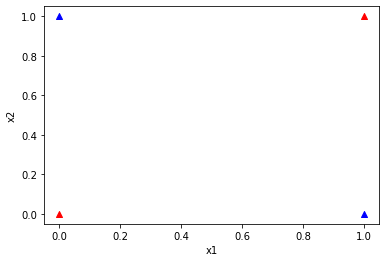

In [4]:
x_data = [[0, 0],
          [0, 1],
          [1, 0],
          [1, 1]]
y_data = [[0],
          [1],
          [1],
          [0]]

plt.scatter(x_data[0][0],x_data[0][1], c='red' , marker='^')
plt.scatter(x_data[3][0],x_data[3][1], c='red' , marker='^')
plt.scatter(x_data[1][0],x_data[1][1], c='blue' , marker='^')
plt.scatter(x_data[2][0],x_data[2][1], c='blue' , marker='^')

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

##  Tensorboard
### 위 Data를 기준으로 XOR처리를 위한 모델을 만들도록 하겠습니다
* 위의 Data를 4Layer의 Neural Network를 통해 학습시킨 후 모델을 생성합니다.
* tensorboard --logdir=./logs/ 실행합니다.
* summary 값을 logs폴더에 저장하고 아래 명령어로 실행해서 확인한다 (http://0.0.0.0:6006)

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).batch(len(x_data))

def preprocess_data(features, labels):
    features = tf.cast(features, tf.float32)
    labels = tf.cast(labels, tf.float32)
    return features, labels

* summary 값을 logs폴더에 저장하고 아래 명령어로 실행해서 확인한다 (http://0.0.0.0:6006)
* tensorboard --logdir=./logs/xor

In [6]:
log_path = "./logs/xor"
writer = tf.summary.create_file_writer(log_path)

### Deep Neural Network를 통해 XOR해결 
* 위의 Data를 4Layer의 Neural Network를 통해 학습시킨 후 모델을 생성합니다. 
* 각각의 값을 histogram으로 tensorboard에 저장한다 (Model)
* 각각의 값을 scalar값으로 tensorboard에 저장한다 (cost, accuracy)

In [7]:
W1 = tf.Variable(tf.random.normal((2, 10)), name='weight1')
b1 = tf.Variable(tf.random.normal((10,)), name='bias1')

W2 = tf.Variable(tf.random.normal((10, 10)), name='weight2')
b2 = tf.Variable(tf.random.normal((10,)), name='bias2')

W3 = tf.Variable(tf.random.normal((10, 10)), name='weight3')
b3 = tf.Variable(tf.random.normal((10,)), name='bias3')

W4 = tf.Variable(tf.random.normal((10, 1)), name='weight4')
b4 = tf.Variable(tf.random.normal((1,)), name='bias4')

def neural_net(features, step):
    layer1 = tf.sigmoid(tf.matmul(features, W1) + b1)
    layer2 = tf.sigmoid(tf.matmul(layer1, W2) + b2)
    layer3 = tf.sigmoid(tf.matmul(layer2, W3) + b3)
    hypothesis = tf.sigmoid(tf.matmul(layer3, W4) + b4)

    with writer.as_default():
        tf.summary.histogram("weights1", W1, step=step)
        tf.summary.histogram("biases1", b1, step=step)
        tf.summary.histogram("layer1", layer1, step=step)

        tf.summary.histogram("weights2", W2, step=step)
        tf.summary.histogram("biases2", b2, step=step)
        tf.summary.histogram("layer2", layer2, step=step)

        tf.summary.histogram("weights3", W3, step=step)
        tf.summary.histogram("biases3", b3, step=step)
        tf.summary.histogram("layer3", layer3, step=step)

        tf.summary.histogram("weights4", W4, step=step)
        tf.summary.histogram("biases4", b4, step=step)
        tf.summary.histogram("hypothesis", hypothesis, step=step)
    return hypothesis

def loss_fn(hypothesis, labels):
    cost = -tf.reduce_mean(labels * tf.math.log(hypothesis) + (1 - labels) * tf.math.log(1 - hypothesis))
    with writer.as_default():
        tf.summary.scalar('loss', cost, step=step)
    return cost

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.float32))
    return accuracy

def grad(hypothesis, features, labels, step):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(neural_net(features, step),labels)
    return tape.gradient(loss_value, [W1, W2, W3, W4, b1, b2, b3, b4])

In [8]:
EPOCHS = 3000

for step in range(EPOCHS):    
    for features, labels  in dataset:
        features, labels = preprocess_data(features, labels)
        grads = grad(neural_net(features, step), features, labels, step)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W1, W2, W3, W4, b1, b2, b3, b4]))
        if step % 50 == 0:
            loss_value = loss_fn(neural_net(features, step),labels)
            print("Iter: {}, Loss: {:.4f}".format(step, loss_value))
x_data, y_data = preprocess_data(x_data, y_data)
test_acc = accuracy_fn(neural_net(x_data, step),y_data)
print("Testset Accuracy: {:.4f}".format(test_acc))

Iter: 0, Loss: 0.9517
Iter: 50, Loss: 0.6936
Iter: 100, Loss: 0.6923
Iter: 150, Loss: 0.6912
Iter: 200, Loss: 0.6901
Iter: 250, Loss: 0.6890
Iter: 300, Loss: 0.6879
Iter: 350, Loss: 0.6867
Iter: 400, Loss: 0.6855
Iter: 450, Loss: 0.6842
Iter: 500, Loss: 0.6827
Iter: 550, Loss: 0.6811
Iter: 600, Loss: 0.6793
Iter: 650, Loss: 0.6772
Iter: 700, Loss: 0.6749
Iter: 750, Loss: 0.6722
Iter: 800, Loss: 0.6690
Iter: 850, Loss: 0.6654
Iter: 900, Loss: 0.6611
Iter: 950, Loss: 0.6561
Iter: 1000, Loss: 0.6502
Iter: 1050, Loss: 0.6432
Iter: 1100, Loss: 0.6349
Iter: 1150, Loss: 0.6251
Iter: 1200, Loss: 0.6134
Iter: 1250, Loss: 0.5992
Iter: 1300, Loss: 0.5821
Iter: 1350, Loss: 0.5612
Iter: 1400, Loss: 0.5357
Iter: 1450, Loss: 0.5047
Iter: 1500, Loss: 0.4677
Iter: 1550, Loss: 0.4248
Iter: 1600, Loss: 0.3774
Iter: 1650, Loss: 0.3281
Iter: 1700, Loss: 0.2798
Iter: 1750, Loss: 0.2356
Iter: 1800, Loss: 0.1971
Iter: 1850, Loss: 0.1649
Iter: 1900, Loss: 0.1385
Iter: 1950, Loss: 0.1173
Iter: 2000, Loss: 0.100

## (Optional) Jupyter Notebook에서 Tensorboard 실행하기

In [7]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [10]:
'''Start TensorBoard through the command line or within a notebook experience. 
The two interfaces are generally the same. In notebooks, use the %tensorboard line magic. 
On the command line, run the same command without "%".'''

%tensorboard --logdir logs/xor

Reusing TensorBoard on port 6006 (pid 23072), started 0:01:00 ago. (Use '!kill 23072' to kill it.)